# MyAcrobot
my custom acrobot rl model for learning, this will have an extended custom environment

### Create my virutal environment

#

pip install virtualenv
virtualenv myenv
source myenv/bin/activate
pip install numpy pandas matplotlib
pip install ipykernel
python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"



pip install virtualenv virtualenv myenv source myenv/bin/activate pip install numpy pandas matplotlib pip install ipykernel python -m ipykernel install --user --name=myenv --display-name "Python (myenv)" 

## Model Code

In [2]:
!pip install gymnasium
!pip install gymnasium[classic-control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 161.5 MB/s eta 0:00:00


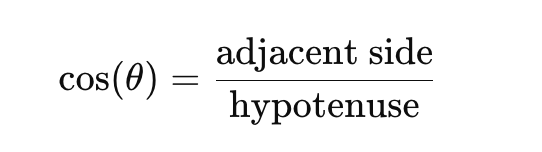

In [6]:
from IPython.display import Image
Image(filename='./images/cos.png', width=500) 

#Scientific Notation

-i pasted this here cause i saw some outputs with e tag. i wanted to know if that was bad to see the e in the state and is a good thing to see.

scientific notation


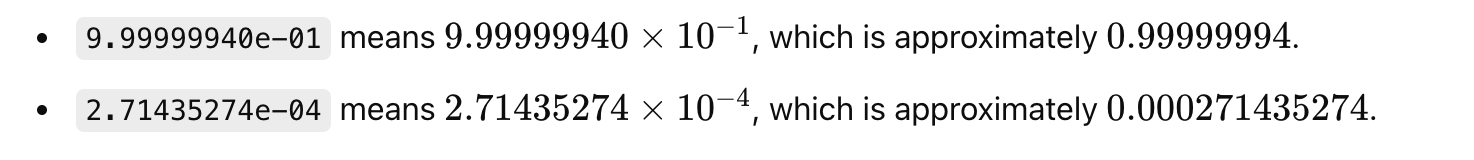

In [8]:
from IPython.display import Image
print("scientific notation")
Image(filename='./images/scientific-notation.png', width=500) 

State: [ 0.99999887  0.00148513  0.99947524 -0.0323913  -0.25021958  0.4103846 ], Reward: -1.0, Done: False, Info: False
after step and render of image
State: [ 0.99943966 -0.03347196  0.9998963   0.01440326 -0.09110426  0.04458576], Reward: -1.0, Done: False, Info: False
after step and render of image
State: [ 0.99821126 -0.05978478  0.99864054  0.05212522 -0.1656579   0.321984  ], Reward: -1.0, Done: False, Info: False
after step and render of image
State: [ 0.99757147 -0.06964993  0.9976808   0.06806672  0.06893535 -0.16586621], Reward: -1.0, Done: False, Info: False
after step and render of image


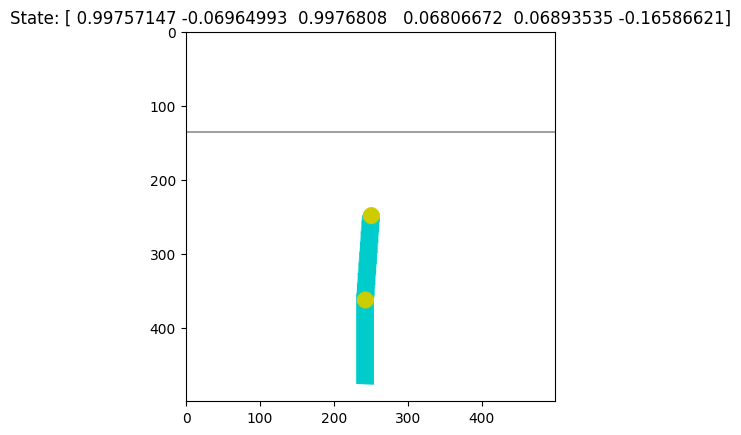

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the environment
env = gym.make('Acrobot-v1', render_mode='rgb_array')
state = env.reset()

# Initialize a figure
fig, ax = plt.subplots()
img = env.render()
im = ax.imshow(img)
ax.axis('on')  

# Define an update function for the animation
def update_frame(frame):
    global state
    # Loop through actions for each frame update
    for _ in range(2):  # Adjust the range to control how many steps per frame
        action = env.action_space.sample()  # Sample a random action
        state, reward, done, info, _ = env.step(action)  # Take a step in the environment
        print(f'State: {state}, Reward: {reward}, Done: {done}, Info: {info}')
        
        # Render the new frame
        img = env.render()
        im.set_array(img)
        plt.title(f'State: {state}')  # Update title with current state
                
        # Reset if done
        if done:
            state = env.reset()

    return [im]

# Create the animation
ani = FuncAnimation(fig, update_frame, frames=100, blit=True, interval=200)  # interval controls the speed

# Display the animation
plt.show()

# Close the environment
env.close()

Length of action space: 3
action is  0
State: [ 0.99816144 -0.06061121  0.99996805 -0.00799556  0.29302087 -0.47871965], Reward: -1.0, Done: False, Info: False
action is  1
State: [ 0.99999774  0.00212145  0.9946771  -0.10304102  0.3189883  -0.4473972 ], Reward: -1.0, Done: False, Info: False
action is  2
State: [ 0.9988793   0.04733011  0.98986226 -0.14203078  0.12327641  0.06734679], Reward: -1.0, Done: False, Info: False
action is  1
State: [ 0.99803513  0.06265686  0.9939863  -0.10950462  0.02820571  0.25708857], Reward: -1.0, Done: False, Info: False
action is  1
State: [ 0.998273    0.05874499  0.9990824  -0.04282941 -0.06441435  0.3994411 ], Reward: -1.0, Done: False, Info: False
action is  0
State: [0.99863416 0.05224755 0.9999561  0.00937579 0.00217835 0.11298083], Reward: -1.0, Done: False, Info: False
action is  2
State: [ 0.99944216  0.03339766  0.9975989   0.06925666 -0.18485299  0.47255892], Reward: -1.0, Done: False, Info: False
action is  1
State: [ 0.9999912  -0.004193

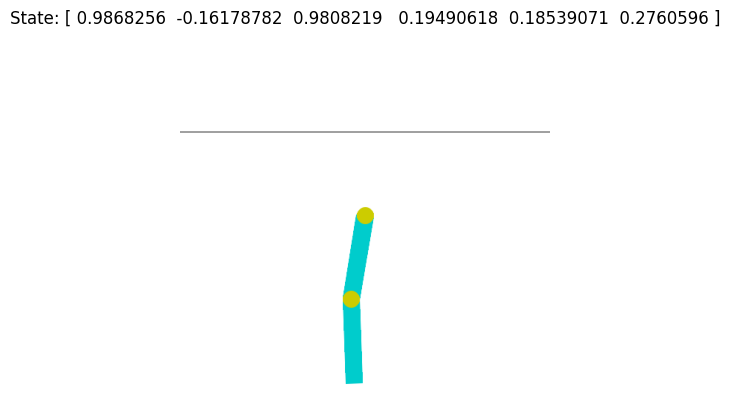

In [18]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the environment
env = gym.make('Acrobot-v1', render_mode='rgb_array')
state = env.reset()

print("Length of action space:", env.action_space.n)

# Initialize a figure
fig, ax = plt.subplots()
img = env.render()
im = ax.imshow(img)
ax.axis('off')  # Turn off the axis

# Define a method to handle the state information and update the frame
def update_frame(frame):
    global state
    # Loop through actions for each frame update
    for _ in range(10):  # Adjust the range to control how many steps per frame
        action = env.action_space.sample()  # Sample a random action
        print("action is ", action)
        state, reward, done, info, _ = env.step(action)  # Take a step in the environment
        print(f'State: {state}, Reward: {reward}, Done: {done}, Info: {info}')
        # Reset if done
        if done:
            state = env.reset()

    # Render the new frame
    img = env.render()
    im.set_array(img)
    plt.title(f'State: {state}')  # Update title with current state

    return [im]

# Create the animation
ani = FuncAnimation(fig, update_frame, frames=100, blit=True, interval=50)  # interval controls the speed

# Display the animation
plt.show()

# Close the environment
env.close()


Initial state: (array([ 9.9970800e-01,  2.4163572e-02,  9.9638206e-01, -8.4987283e-02,
        3.6662940e-02, -8.5258915e-04], dtype=float32), {})
State: [ 0.99964356  0.02669787  0.99725956 -0.0739823  -0.01142294  0.10962421]


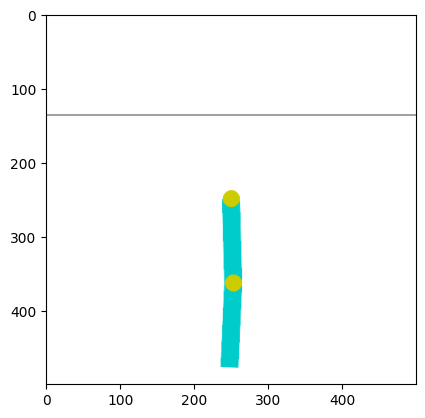

State: [ 0.9994457   0.03329246  0.9970257  -0.07706945  0.07582288 -0.13874911]
State: [ 0.9984638   0.05540808  0.99198824 -0.12633021  0.13937066 -0.3442176 ]
State: [ 0.99631727  0.0857435   0.97839975 -0.20672187  0.15594749 -0.45243794]
State: [ 0.99350023  0.11383034  0.9555198  -0.2949269   0.11791573 -0.43951663]
State: [ 0.9945771   0.10400168  0.9524752  -0.3046162  -0.21441878  0.33708426]
State: [ 0.99897075  0.04535891  0.9790924  -0.20341578 -0.3590016   0.68391764]
State: [ 0.9989799  -0.04515617  0.99988097 -0.0154277  -0.52220297  1.1635898 ]
State: [ 0.98852396 -0.15106422  0.9720323   0.23484726 -0.5118923   1.2990248 ]
State: [ 0.97477204 -0.2232029   0.9021747   0.43137088 -0.20373894  0.74931574]
State: [ 0.97101694 -0.23901069  0.84786266  0.53021586  0.04624191  0.3615418 ]
State: [ 0.9786722  -0.20542814  0.83252615  0.5539858   0.29126936 -0.07726539]
State: [ 0.99312234 -0.11708143  0.87781614  0.47899774  0.5848943  -0.77555776]
State: [ 0.9995643   0.02951

In [14]:
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the Acrobot environment with render mode
env = gym.make('Acrobot-v1', render_mode='rgb_array')

# Reset the environment
state = env.reset()
print("Initial state:", state)

# Set up the Matplotlib figure and axis
fig, ax = plt.subplots()
img = env.render()  # Render the first frame
im = ax.imshow(img)  # Display the first frame

# Turn off the axis
#ax.axis('off')

# Function to update the frame
def update_frame():
    action = env.action_space.sample()  # Sample a random action
    state, reward, done, info, _ = env.step(action)  # Take a step in the environment
    
    img = env.render()  # Get the new frame
    im.set_data(img)  # Update the displayed frame
    fig.canvas.flush_events()  # Update the canvas with the new frame
    
    print("State:", state)
    
    return done

# Run the loop to animate the plot
plt.ion()  # Turn on interactive mode
for _ in range(100):  # Run for a fixed number of frames or until done
    done = update_frame()
    plt.pause(0.01)  # Pause to control the frame rate
    
    if done:
        state, _ = env.reset()  # Reset the environment if done

plt.ioff()  # Turn off interactive mode
env.close()  # Close the environment


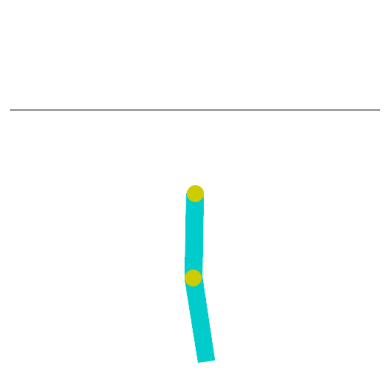

In [5]:
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the Acrobot-v1 environment with render mode 'rgb_array'
env = gym.make('Acrobot-v1', render_mode='rgb_array')

# Reset the environment to the initial state
state, _ = env.reset()

# Set up the figure and axis
fig, ax = plt.subplots()
img = env.render()
im = ax.imshow(img)
plt.axis('off')  # Turn off the axis

def update(frame):
    global state
    action = env.action_space.sample()  # Sample a random action
    state, reward, done, _, info = env.step(action)  # Take a step in the environment

    img = env.render()  # Render the environment and get the image
    im.set_array(img)  # Update the image data

    if done:
        state, _ = env.reset()  # Reset the environment if done

    return [im]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=200, blit=True, interval=50, repeat=True)

plt.show()

env.close()  # Close the environment